In [1]:
import numpy as np
import os
from ddlraw import Raw
from ddldetect import Detect
from ddlsorted import Sorted
from ddlneurons import Neurons

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
20:51:16 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
recording_name = '20160415_patch2'
Dir = os.path.join('C:/Users/liuxj/Desktop/BMEMajor/zhuanyeshijianzonghexunlian2/raw_data',recording_name)
file_name = 'patch_2_MEA.raw'
offset=1871
data = np.memmap(os.path.join(Dir,file_name),dtype='uint16',offset=offset,mode='r')
data = data.reshape(len(data)//256,256)
data = data[:,7:9]#选取示例电极，其中7号电极可以较好地看到两个神经元的信号
data = data.astype('float32')

time_series = np.array(data)
Fs = 20000
print(type(time_series))
print(Fs)

<class 'numpy.ndarray'>
20000


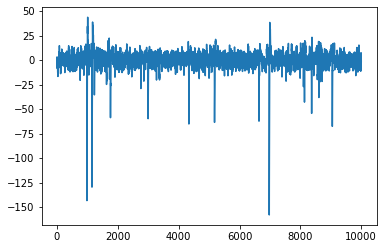

In [3]:
import matplotlib.pyplot as plt
#观察原始波形
raw = Raw(time_series,Fs)
raw.scale(1,-2**15-1)
raw.scale(0.1042,0)
raw.set_unit('uV')
raw.set_channels_locs(np.array([[1,1,1],[0,0,0]]))
plt.plot(raw.data[0:10000,0])
plt.show()

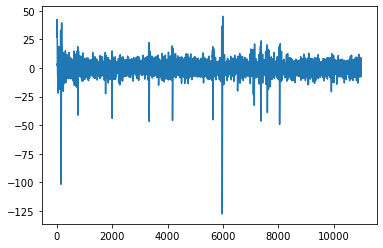

In [4]:
#滤波
spikes = raw.get_spikes()
plt.plot(spikes.data[1000:12001,0])
plt.show()

In [5]:
#峰值检测
detect = spikes.extract_by_median(5)
print(detect.n_spikes)


[7033 2926]


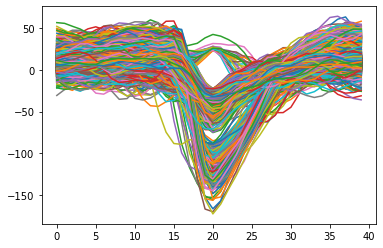

In [6]:
#观察波形分布
waveforms = detect.waveforms[0]
for i in range(np.shape(waveforms)[0]):
    plt.plot(waveforms[i,:])

In [9]:
#去除疑似非锋电位的正向波形
nega = detect.mannual_select_by_peaks(list(range(detect.n_channels)),[float('-inf') for i in range(detect.n_channels)],np.zeros([detect.n_channels]))
print(nega.n_spikes)

[7009 2886]


In [10]:
#使用“自然断点”法分类
sorted_result = nega.sort_by_natural_break()

Divide into 3 classes
[-172.17512631560407, -84.88179346360639, -37.213628409159526, -22.684113020206944]
Divide into 3 classes
[-90.82497141445856, -35.03416395215371, -25.354315756201707, -16.58132626480143]


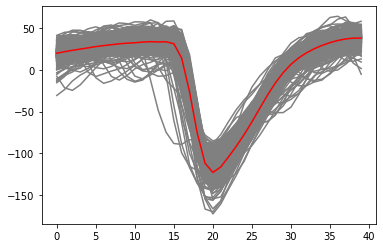

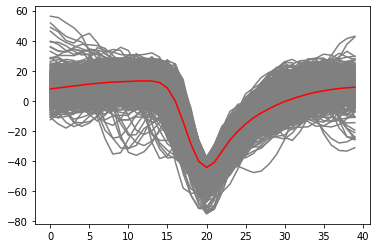

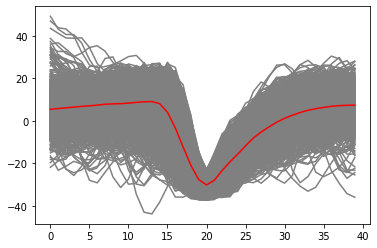

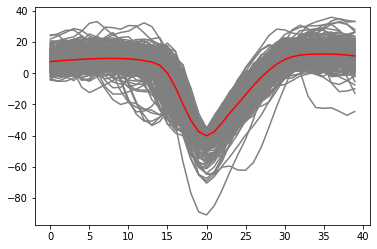

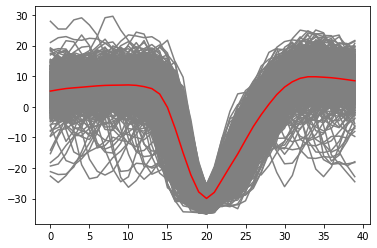

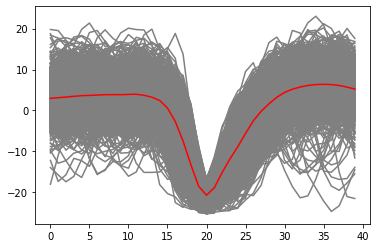

In [8]:
#绘制分出的每个神经元的平均波形
sorted_result.plot_neuron(0)
sorted_result.plot_neuron(1)

[ 2.61        7.41       13.34333333]
[1.75       3.23666667 4.63333333]


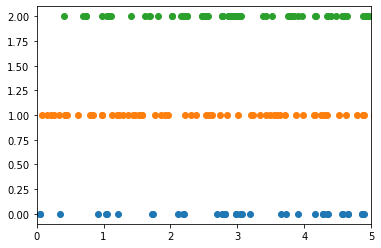

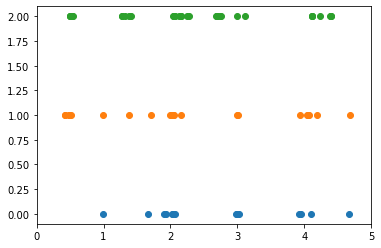

In [9]:
#绘制每个神经元的发放时刻，如下图所示，第1、2个神经元发放时刻高度相关，似应为同一个，在连续发放时幅值变小，被自动分类为两个
for ch in range(sorted_result.n_channels):
    print(sorted_result.firing_rate[ch])
    plt.figure()
    for i in range(sorted_result.n_neurons[ch]):
        plt.scatter(sorted_result.time_points[ch][i],[i for ii in range(len(sorted_result.time_points[ch][i]))])
        plt.xlim([0,5])

In [11]:
#两种分类后结果数据类型相互转换
print(sorted_result.channels_locs)
neurons = sorted_result.to_Neurons()
back = neurons.to_Sorted()
print(type(back.result[0][1]))
print(sorted_result.time_points==back.time_points)
print(sorted_result.neuron_id==back.neuron_id)
print(neurons.neurons_locs)

[[1 1 1]
 [0 0 0]]
<class 'numpy.ndarray'>
True
True
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


isi_threshold= 0.08240000000000691
lamda= 0.08883642713764811


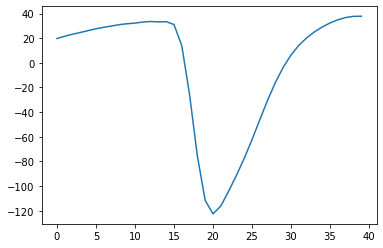

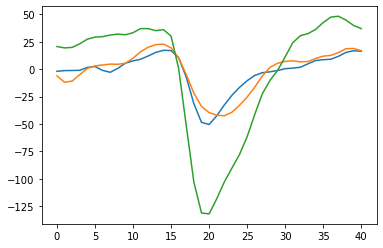

isi_threshold= 0.08254999999999768
lamda= 0.02478595973275835


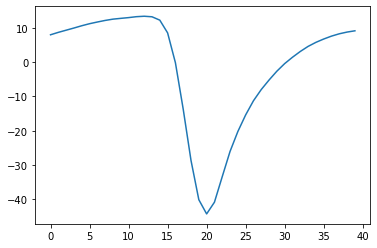

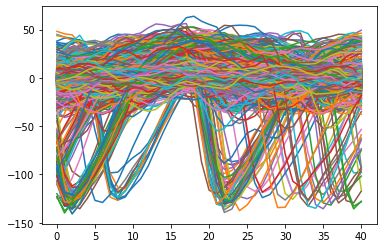

isi_threshold= 0.09040000000001669
lamda= -0.00010315873401925952
isi_threshold= 0.059449999999998226
lamda= -0.029267843983582634
isi_threshold= 0.052149999999983265
lamda= 0.004295020254444341


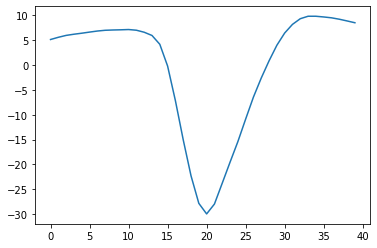

isi_threshold= 0.06295000000000073
lamda= 0.011375473085040621


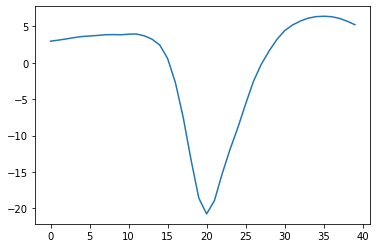

TypeError: __init__() missing 1 required positional argument: 'unit'

In [12]:
#试了一下基于模板匹配的burst检测，效果比较奇怪，会匹配到很多一看就不对劲的东西
neo_neurons = neurons.find_bursts(spikes,200)

In [18]:
for i in range(neurons.n_neurons):
    print(np.shape(neo_neurons.time_points[i]))
    print(np.shape(neurons.time_points[i]))

(784,)
(783,)
(7614,)
(2223,)
(4003,)
(4003,)
(525,)
(525,)
(971,)
(971,)
(1390,)
(1390,)


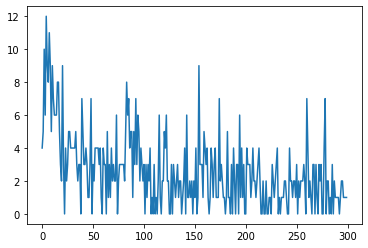

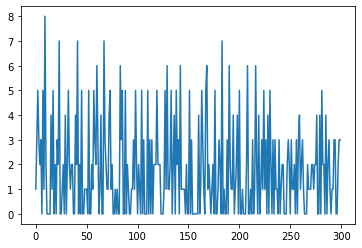

In [21]:
#计算神经元发放率随时间的变化
fr = neurons.get_firing_rate(1)
plt.plot(fr[0])
plt.show()
plt.plot(fr[3])

explained_variance_ratio [0.79318862 0.0692313  0.04290723]
explained_variance_ratio [0.45938303 0.16047642 0.0952353 ]


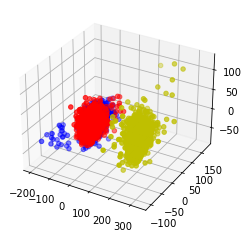

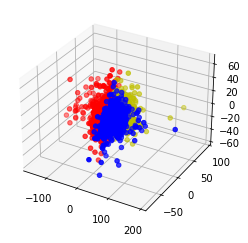

In [6]:
from ddltools import PCAanalysis

#pca_results,kmeans_results = PCAanalysis.pca_kmeans(detect,3,3)
#print(kmeans_results)
#PCAanalysis.plot_pca(pca_results,kmeans_results)
pca_sorted = detect.sort_by_pca(3,3)

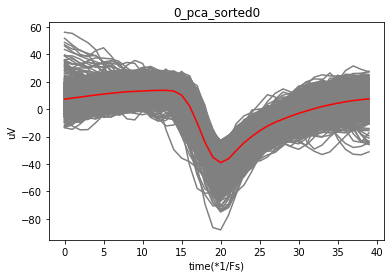

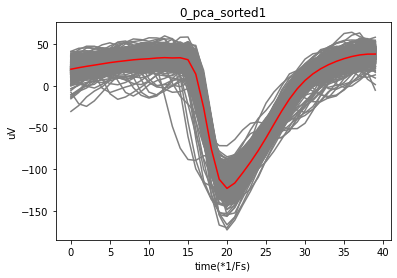

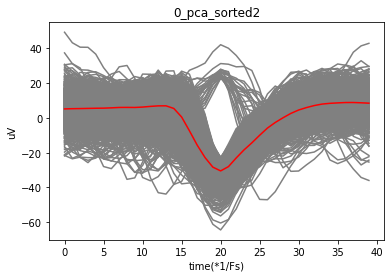

In [7]:
pca_sorted.plot_neuron(0)